In [1]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.16.1
Keras version: 3.3.3


In [2]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import Add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

**Đọc và lưu các dữ liệu text mô tả cho ảnh**

In [3]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:300])
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

descriptions['1000268201_693b08cb0e']

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s
Loaded: 8092 


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

**Tiền xử lý cho đoạn text mô tả ảnh**

In [4]:
# Preprocessing text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Lưu file mô tả ảnh**

In [5]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, '/kaggle/working/descriptions.txt')

**Lấy dữ liệu ảnh train test val**

In [6]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
filename2= '/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr_8k.devImages.txt'
train = load_set(filename).union(load_set(filename2))
print('Dataset: %d' % len(train))

Dataset: 7000


**Lấy đường dẫn của ảnh train test**

In [7]:
# Folder chứa dữ ảnh
images = '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset'

# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '/*.jpg')

# File chứa các id ảnh để train
train_images_file = '/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images)+1:] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

# File chứa các id ảnh để val = train2
val_images_file = '/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr_8k.devImages.txt'
# Read the train image names in a set
train2_images = set(open(val_images_file, 'r').read().strip().split('\n'))
# Create a list of all the training images with their full path names
train2_img = []
for i in img: # img is list of full path names of all images
    if i[len(images)+1:] in train2_images: # Check if the image belongs to training set
        train2_img.append(i) # Add it to the list of train images
        
# cộng data train = tệp train + tệp val => tối ưu dữ liệu
train_img=train_img+train2_img

# File chứa các id ảnh để test
test_images_file = '/kaggle/input/imange-captioning-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Create a list of all the test images with their full path names
test_img = []
for i in img: # img is list of full path names of all images
    if i[len(images)+1:] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
        
print("Đường dẫn của ảnh train",train_img[:5])  #đường dẫn của ảnh train
print("Đường dẫn của ảnh train",test_img[:5]) #đường dẫn của ảnh test

print("Số ảnh dùng để train",len(train_img))
print("Số ảnh dùng để test",len(train_img))

Đường dẫn của ảnh train ['/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/3226254560_2f8ac147ea.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/214543992_ce6c0d9f9b.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/3368819708_0bfa0808f8.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/2190227737_6e0bde2623.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/2752809449_632cd991b3.jpg']
Đường dẫn của ảnh train ['/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/280706862_14c30d734a.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/929679367_ff8c7df2ee.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/1317292658_ba29330a0b.jpg', '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/3411393875_a9ff73c67a.jpg', '/kaggle/input/im

**Xử lý chuỗi text mô tả**

In [8]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/kaggle/working/descriptions.txt', train)
print('Số lượng mô tả cho train=%d' % len(train_descriptions))
print("Ví dụ ảnh: ",list(train_descriptions.keys())[2])
print("Mô tả của ảnh",list(train_descriptions.values())[2])


Số lượng mô tả cho train=7000
Ví dụ ảnh:  1002674143_1b742ab4b8
Mô tả của ảnh ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq', 'startseq there is girl with pigtails sitting in front of rainbow painting endseq', 'startseq young girl with pigtails painting outside in the grass endseq']


**Xử lý ảnh với mô hình InceptionV3**

In [9]:
    # Load ảnh, resize về khích thước mà Inception v3 yêu cầu.
    def preprocess(image_path):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        img = image.load_img(image_path, target_size=(299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = image.img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis=0)
        # preprocess the images using preprocess_input() from inception module
        x = preprocess_input(x)
        return x
        
    from time import time
    # Load the inception v3 model
    model = InceptionV3(weights='imagenet')
    
    # Tạo model mới, bỏ layer cuối từ inception v3
    model_new = Model(model.input, model.layers[-2].output)
    
    
    # Image embedding thành vector (2048, )
    def encode(image):
        image = preprocess(image) # preprocess the image
        fea_vec = model_new.predict(image,verbose=0) # Get the encoding vector for the image
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        return fea_vec
    
    # Gọi hàm encode với các ảnh trong traning set
    start = time()
    encoding_train = {}
    for img in train_img:
        encoding_train[img[len(images)+1:]] = encode(img)
    print("Time taken in seconds =", time()-start)
    
    # Encode test image
    start = time()
    encoding_test = {}
    for img in test_img:
        encoding_test[img[len(images)+1:]] = encode(img)
    print("Time taken in seconds =", time()-start)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


I0000 00:00:1732210191.240205      65 service.cc:145] XLA service 0x7f9730003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732210191.240270      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732210196.127501      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Time taken in seconds = 532.9625082015991
Time taken in seconds = 77.74262976646423


**Lưu lại file econder của ảnh**

In [10]:
print("Ví dụ Ecoding cho 1 ảnh Train: ",list(encoding_train.keys())[2])
print(list(encoding_train.values())[2])

print("Ví dụ Ecoding cho 1 ảnh Test:",list(encoding_test.keys())[2])
print(list(encoding_test.values())[2])
# Đường dẫn thư mục
pickle_dir = "/kaggle/working/Pickle"

# Kiểm tra và tạo thư mục nếu chưa tồn tại
os.makedirs(pickle_dir, exist_ok=True)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_train_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)


# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_test_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

model_new.save('/kaggle/working/inception_v3_feature_extractor.h5')

Ví dụ Ecoding cho 1 ảnh Train:  3368819708_0bfa0808f8.jpg
[0.21177876 0.14312969 0.23457353 ... 0.9280492  0.2357117  0.3648153 ]
Ví dụ Ecoding cho 1 ảnh Test: 1317292658_ba29330a0b.jpg
[0.04632988 0.11090325 0.16118297 ... 0.40154743 1.0073888  0.5784725 ]


**Tải encoding ảnh, xử lý cho all mô tả (chỉ giữ lại những từ mà xuất hiện trên 10 lần trong số tất cả các mô tả)**

In [11]:
train_features = load(open("/kaggle/working/Pickle/encoded_train_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh train = %d\n' % len(train_features))

# Tạo list các training caption
all_train_captions = []  
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
print("5 mô tả đầu tiên của tất cả mô tả: ",all_train_captions[:5])
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('\nXử lý từ %d từ vựng -> xuống còn %d từ vựng\n' % (len(word_counts), len(vocab)))
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
print("Danh sách từ điển từ: ",wordtoix)
# print("Từ điển từ",ixtoword) 
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding

print("\nVocab_size= ",vocab_size)

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('\nĐộ dài lớn nhất của một mô tả: %d' % max_length)

Số lượng vecto encoding ảnh train = 7000

5 mô tả đầu tiên của tất cả mô tả:  ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']

Xử lý từ 8169 từ vựng -> xuống còn 1797 từ vựng

Danh sách từ điển từ:  {'startseq': 1, 'child': 2, 'in': 3, 'pink': 4, 'dress': 5, 'is': 6, 'climbing': 7, 'up': 8, 'set': 9, 'of': 10, 'stairs': 11, 'an': 12, 'way': 13, 'endseq': 14, 'girl': 15, 'going': 16, 'into': 17, 'wooden': 18, 'building': 19, 'little': 20, 'the': 21, 'to': 22, 'her': 23, 'black': 24, 'dog': 25, 'and': 26, 'spotted': 27, 'are': 28, 'fighting': 29, 'tricolored': 30, 'playing': 31, 'with': 32, 'each': 33, 'other': 34, 'on': 35, 'road': 36, 'white': 37, 'brown': 38, 'spots': 39, 'staring': 40, 'at': 41, 'stree

In [12]:
import pickle

# Lưu từ điển wordtoix vào file
with open('/kaggle/working/Pickle/wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

# Lưu từ điển ixtoword vào file
with open('/kaggle/working/Pickle/ixtoword.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

print("Đã lưu thành công wordtoix và ixtoword.")


Đã lưu thành công wordtoix và ixtoword.


**Xử lý embeddings cho chuỗi text mô tả sử dụng word embedding Glove model**

In [13]:
# Load Glove model
glove_dir = '/kaggle/input/imange-captioning-dataset/glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']

embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():  # duyệt trong từ điển từ
    #if i < max_words:
    embedding_vector = embeddings_index.get(word) # embecdding cho từ đó 
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print("\nCấu hình của ma trận vecto embedding cho từ điển từ:",embedding_matrix.shape)

print('\nVí dụ từ thứ nhất: ',list(wordtoix.keys())[1])
print('Ma trận embedding: ',embedding_matrix[1])

print('\nVí dụ từ thứ hai: ',list(wordtoix.keys())[2])
print('Ma trận embedding: ',embedding_matrix[2])

Found 400000 word vectors.

Cấu hình của ma trận vecto embedding cho từ điển từ: (1798, 300)

Ví dụ từ thứ nhất:  child
Ma trận embedding:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

**Hàm xử lý huấn luyện mô hình**

In [14]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key + '.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == num_photos_per_batch:
                yield ((np.array(X1), np.array(X2)), np.array(y))  
                X1, X2, y = [], [], []
                n = 0

**Cấu tạo của mô hình**

In [15]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid')(se2)
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.optimizer.lr = 0.0001
epochs = 300
number_pics_per_bath = 16
steps = len(train_descriptions)//number_pics_per_bath

**Huấn luyện mô hình**

In [16]:
from itertools import islice

for key, value in islice(train_features.items(), 5):
    print(f"Key: {key}, Value: {value}")
    
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Key: 3226254560_2f8ac147ea.jpg, Value: [0.23555516 0.28298867 0.42571765 ... 0.46947825 0.28000188 0.2839393 ]
Key: 214543992_ce6c0d9f9b.jpg, Value: [0.63332593 0.20056595 0.44488803 ... 0.14376743 0.9883684  0.21706833]
Key: 3368819708_0bfa0808f8.jpg, Value: [0.21177876 0.14312969 0.23457353 ... 0.9280492  0.2357117  0.3648153 ]
Key: 2190227737_6e0bde2623.jpg, Value: [0.22736686 0.560628   0.24622986 ... 0.12553631 0.51900554 0.1716778 ]
Key: 2752809449_632cd991b3.jpg, Value: [0.3081796  0.53958064 0.40372378 ... 0.47448176 1.1557084  0.2711777 ]
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - loss: 4.9268
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 3.5860
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 3.2967
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 3.1408
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 3.0320
437/437 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 2.9518
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 2.8826
437/437 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/st

**Lưu mô hình**

In [17]:
model.save_weights('/kaggle/working/model_images_captioning.weights.h5')
model.save('/kaggle/working/model_images_captioning.h5')

**Test với ảnh trong data test**

In [18]:
images = '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
with open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

3295680663_af21ea648b.jpg
[0.2565276  0.6527776  0.15890622 ... 0.4124393  0.14316517 0.01913082]


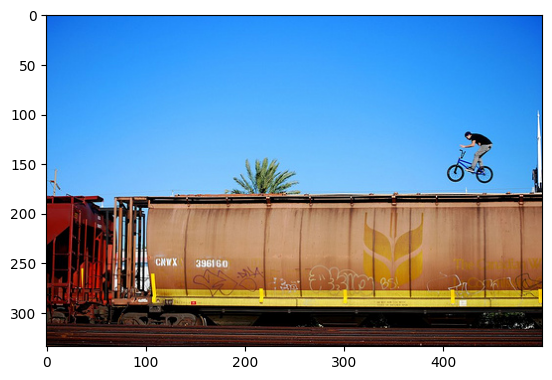

Caption:  the little girl is holding red stick up to her head


In [19]:
# Chọn ảnh từ encoding_test với chỉ số z
z = 326
pic = list(encoding_test.keys())[z]
print(pic)
print(encoding_test[pic])
# Trích xuất đặc trưng của ảnh từ encoding_test và chuẩn hóa lại kích thước
image = encoding_test[pic].reshape((1, 2048))

# Đọc và hiển thị ảnh
x = plt.imread(images + '/' + pic)
plt.imshow(x)
plt.show()

# Gọi hàm greedySearch để tạo chuỗi mô tả cho ảnh
caption = greedySearch(image)
print("Caption: ", caption)

**Test với một ảnh bất kỳ , load mô hình lên**

In [20]:
import numpy as np
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt

# Định nghĩa hàm tiền xử lý ảnh
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))  # Resize về kích thước 299x299
    x = image.img_to_array(img)  # Chuyển ảnh thành mảng numpy
    x = np.expand_dims(x, axis=0)  # Thêm một chiều cho batch
    x = preprocess_input(x)  # Tiền xử lý ảnh theo yêu cầu của InceptionV3
    return x

# Tải mô hình InceptionV3 (đã loại bỏ lớp cuối)
model_new = load_model('/kaggle/working/inception_v3_feature_extractor.h5')

# Định nghĩa hàm trích xuất đặc trưng ảnh
def encode(image_path):
    image = preprocess(image_path)  # Tiền xử lý ảnh
    feature_vector = model_new.predict(image, verbose=0)  # Lấy đặc trưng ảnh
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])  # Đổi hình dạng thành (2048, )
    return feature_vector

# Tải mô hình captioning đã huấn luyện
model = load_model('/kaggle/working/model_images_captioning.h5')

# Tải các từ điển
with open('/kaggle/working/Pickle/wordtoix.pkl', 'rb') as f:
    wordtoix = pickle.load(f)
with open('/kaggle/working/Pickle/ixtoword.pkl', 'rb') as f:
    ixtoword = pickle.load(f)

# Hàm tìm kiếm bằng phương pháp greedy (dự đoán chuỗi mô tả)
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]  # Bỏ 'startseq' và 'endseq'
    final = ' '.join(final)
    return final

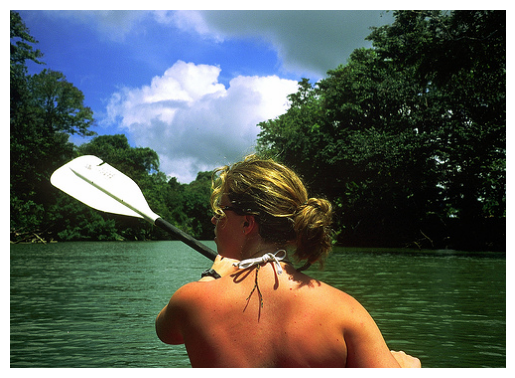

Caption:  woman kayaking on water


In [21]:
# Chọn ảnh cần test
img_path = '/kaggle/input/imange-captioning-dataset/Flickr8k_Dataset/Flicker8k_Dataset/105342180_4d4a40b47f.jpg'  # Đặt đường dẫn tới ảnh cần test

# Trích xuất đặc trưng ảnh
image_encoding = encode(img_path).reshape((1, 2048))
# Hiển thị ảnh
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Dự đoán caption cho ảnh
caption = greedySearch(image_encoding)
print("Caption: ", caption)
